# Notebook to match VASCA sources to SIMBAD database sources positionally
Set your option in the cell bellow

In [1]:
from astropy import units as uu
region_name = "ALL_10-800" #"CAINGSGII_10-800" #"TDS" #"CAINGSGII_10-800" #"WD" #"MDIS_10-800" #"TDS" #  _ELAISN1
region_cat_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+"_cat.fits"
simbad_query = True     #Run simbad querry, otehrwise SIMBAD association information already in region file. Will overwrite prexisting SIMBAD info if True.
redo_reg_cat = False     # Redo region catalog before running
query_radius = 2 * uu.arcsec
match_radius = 1 * uu.arcsec

In [2]:
%matplotlib widget
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from vasca.region import Region
import vasca.visualization as vvis
from vasca.utils import otype2ogroup,dd_ogrp2otypes, dd_ogrp2col, get_col_cycler,add_ogrp

if redo_reg_cat:
    region_fname = "./vasca_pipeline/"+region_name+"/region_"+region_name+".fits"
    rg = Region()
    rg.load_from_fits(region_fname)
    rg.tt_fields["sel"] = np.ones(len(rg.tt_fields), dtype=bool) 
    rc = rg.get_region_catalog()
    rc.write_to_fits(region_cat_fname)

# Get region
rc = Region()
rc.load_from_fits(region_cat_fname)

### Query the SIMBAD data or read from file

In [3]:
if simbad_query:
    rc.cross_match_simbad(query_radius = query_radius, match_radius = match_radius, overwrite=True)
    display(rc.tt_simbad[rc.tt_simbad["otype"]=="WD*"])
    rc.write_to_fits(region_cat_fname)
add_ogrp(rc,"tt_sources")
add_ogrp(rc,"tt_otypes")
display(rc.tt_sources[:2])
display(rc.tt_simbad)

main_id,ra,dec,ra_prec,dec_prec,coo_err_maja,coo_err_mina,coo_err_angle,coo_qual,coo_wavelength,coo_bibcode,otype,otypes,distance_distance,distance_q,distance_unit,distance_merr,distance_perr,distance_method,distance_bibcode,distance_result,rvz_type,rvz_radvel,rvz_error,rvz_qual,rvz_wavelength,rvz_bibcode,z_value,sp_type,sp_qual,sp_bibcode,script_number_id,rg_src_id,match_id
,deg,deg,,,mas,mas,deg,,,,,,,,,,,,,arcsec,,km / s,km / s,,,,,,,,,,
bytes32,float64,float64,int16,int16,float32,float32,int16,str1,str1,bytes32,bytes32,bytes32,float64,str1,str4,float64,float64,str8,str19,float32,str1,float64,float32,str1,str1,bytes32,float64,bytes32,bytes32,bytes32,int32,int32,int32
PB 5130,334.61909791666665,-0.003382777777777778,14,14,0.145,0.133,90,A,O,2020yCat.1350....0G,WD*,WD*|WD*|WD*|WD*|*|Opt|UV|WD?|WD?,121.7450,,pc,-2.5167,2.5167,paral,2020yCat.1350....0G,0.3802,z,1.330,0.002,D,,2008ApJS..175..297A,1.3299500,DAH,D,2013ApJS..204....5K,1416,61491,1073
GALEX J221409.8+005245,333.5413925,0.8793602777777778,14,14,0.401,0.424,90,A,O,2020yCat.1350....0G,WD*,WD*|WD*|WD*|*|Opt|UV,439.0000,,pc,--,--,Sp-T,2011ApJS..197...38D,0.2767,,--,--,,,,--,DC,D,2013ApJS..204....5K,1483,64360,1130
GALEX J234829.1-092500,357.1212070833333,-9.416926666666667,14,14,0.440,0.324,90,A,O,2020yCat.1350....0G,WD*,WD*|**|WD*|WD*|EB*|WD*|*|Opt|UV,507.2900,,pc,-113.7400,113.7400,ST-L,2017MNRAS.469.2102A,0.6189,v,-18.030,31.850,C,O,2017MNRAS.469.2102A,-0.0000600,DA,D,2016MNRAS.455.3413K,4432,267514,3010
GALEX J140000.3+031251,210.00146291666664,3.2144083333333335,14,14,0.186,0.135,90,A,O,2020yCat.1350....0G,WD*,WD*|WD*|WD*|WD*|WD*|WD*|*|Opt|UV,313.7650,,pc,-20.6052,20.6052,paral,2020yCat.1350....0G,0.1945,v,19.000,10.000,D,O,2019MNRAS.486.2169K,0.0000630,DA,D,2006ApJS..167...40E,5837,588567,3958


fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,otype,main_id,otypes,z_value,distance_distance,distance_unit,distance_result,ogrp
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,,,arcsec,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,bytes32,bytes32,bytes32,float64,float64,str4,float32,bytes8
-1,175 .. 98,150.19491746654782,2.067917488917891,0.041145824,-0.33278635,0.15272313,1.0,0.30049813,867,0.063385345,1 .. 2,True,14.334563 .. 8.805813,0.07181169 .. 0.109138064,0.010237182 .. 0.009757584,3.5745542 .. 2.283225,0.0 .. 3.814655e-12,3.7095704 .. 2.3172796,0.97875947 .. 1.0259458,-3.2490458 .. 1.6797316,-1,26,10,0.6041421,0.008988117,Sy1,2XMM J100046.7+020404,Sy1|AGN|AGN|AGN|AGN|AGN|*|AG?|G|,0.5524000,--,,0.7003,AGN
-1,148 .. 130,150.1799556325474,2.1103312162731735,0.041883517,-0.28210574,0.24747498,1.0,0.4775786,67,0.04405546,1 .. 2,True,17.591288 .. 6.566322,0.091125205 .. 0.082030274,0.002693037 .. 0.0027621754,2.8632436 .. 1.2160017,1.9439212e-11 .. 0.48239988,1.9737328 .. 1.0003253,0.98499906 .. 1.0091033,-2.4839041 .. 0.59337366,-1,31,10,0.36145002,0.0069398326,GrG,[AFH2012] 110,GrG|GrG|X,0.3610000,--,,0.6119,GAL


main_id,ra,dec,ra_prec,dec_prec,coo_err_maja,coo_err_mina,coo_err_angle,coo_qual,coo_wavelength,coo_bibcode,otype,otypes,distance_distance,distance_q,distance_unit,distance_merr,distance_perr,distance_method,distance_bibcode,distance_result,rvz_type,rvz_radvel,rvz_error,rvz_qual,rvz_wavelength,rvz_bibcode,z_value,sp_type,sp_qual,sp_bibcode,script_number_id,rg_src_id,match_id
,deg,deg,,,mas,mas,deg,,,,,,,,,,,,,arcsec,,km / s,km / s,,,,,,,,,,
bytes32,float64,float64,int16,int16,float32,float32,int16,str1,str1,bytes32,bytes32,bytes32,float64,str1,str4,float64,float64,str8,str19,float32,str1,float64,float32,str1,str1,bytes32,float64,bytes32,bytes32,bytes32,int32,int32,int32
2XMM J100046.7+020404,150.19472291666665,2.067906388888889,14,14,2.287,3.314,90,C,O,2020yCat.1350....0G,Sy1,Sy1|AGN|AGN|AGN|AGN|AGN|*|AG?|G|,--,,,--,--,,,0.7003,z,0.552,0.000,C,O,2009ApJ...696.1195T,0.5524000,,,,1,26,0
[AFH2012] 110,150.17979,2.11037,8,8,--,--,0,D,X,2012ApJ...758...47A,GrG,GrG|GrG|X,--,,,--,--,,,0.6119,z,0.361,--,D,O,2012ApJ...758...47A,0.3610000,,,,2,31,1
SDSS J100043.13+020637.2,150.17970791666664,2.110389722222222,14,14,3.609,4.120,90,C,O,2020yCat.1350....0G,QSO,AGN|FIR|AGN|BiC|Sy1|AGN|AGN|QSO|,--,,,--,--,,,0.9146,z,0.360,0.001,C,O,2009ApJ...696.1195T,0.3596000,,,,2,31,2
[VV2006] J100034.9+020235,150.14558874999997,2.043054722222222,14,14,1.578,2.045,90,C,O,2020yCat.1350....0G,QSO,QSO|AGN|QSO|AGN|AGN|AGN|AGN|AGN|,--,,,--,--,,,0.5972,z,1.177,0.001,C,O,2009ApJ...696.1195T,1.1767000,,,,3,47,3
[VV2006] J100024.5+020619,150.1020008333333,2.1054636111111114,14,14,0.523,0.544,90,A,O,2020yCat.1350....0G,QSO,AGN|QSO|AGN|QSO|QSO|AGN|QSO|QSO|,--,,,--,--,,,0.7379,z,2.290,0.000,C,O,2009ApJ...696.1195T,2.2900000,,,,4,65,4
zCOSMOS 830948,150.25753749999998,2.429861111111111,7,7,--,--,0,C,O,2009ApJS..184..218L,G,G|G|G|G,--,,,--,--,,,0.6634,z,0.122,0.000,C,O,2018ApJS..234...21D,0.1217700,,,,5,134,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cl* NGC 104 WSB V12,6.679109166666666,-72.25575916666666,14,14,0.044,0.039,90,A,O,2020yCat.1350....0G,EB*,EB*|EB*|NIR|V*|*,--,,,--,--,,,0.6722,,--,--,,,,--,,,,7110,979263,4713


### Create matching table

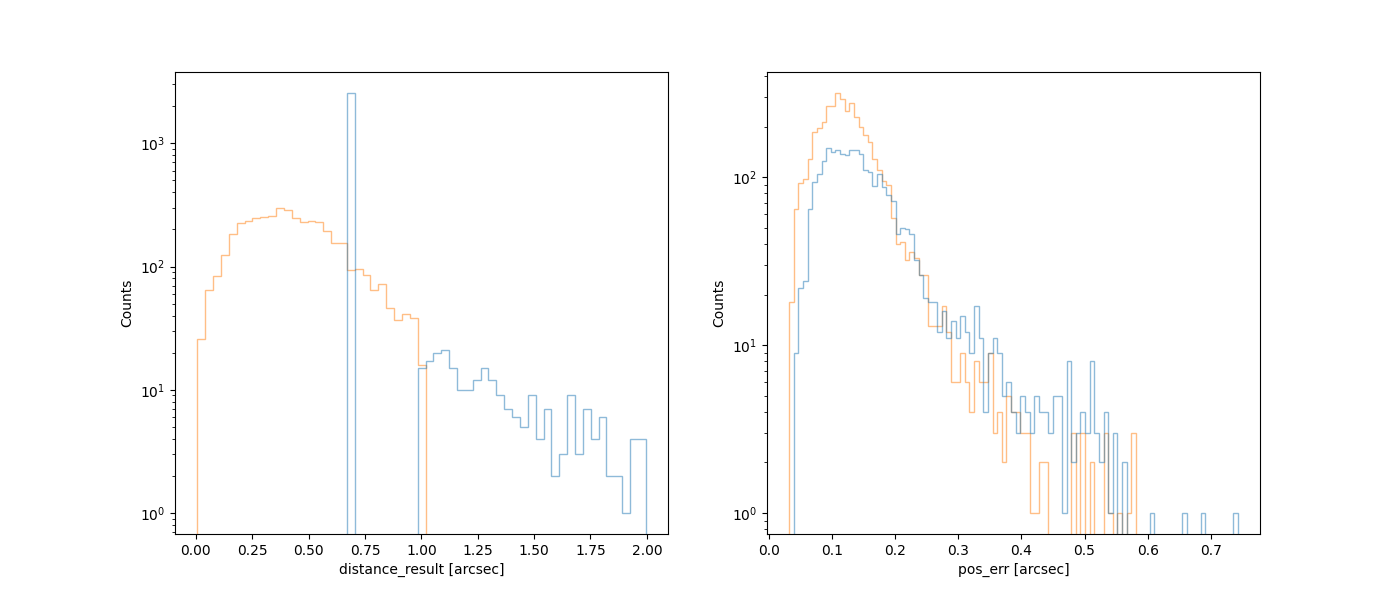

In [4]:
fig, axs = plt.subplots(1, 2, figsize=(14, 6))
axs = np.array(axs).flatten()
_ = vvis.plot_table_hist(rc.tt_sources, "distance_result", ax=axs[0], logx=False, obs_filter_id=None, density= False)
_ = vvis.plot_table_hist(rc.tt_sources, 'pos_err', ax=axs[1], logx=False, obs_filter_id=None, density= False)

### Plot found object types

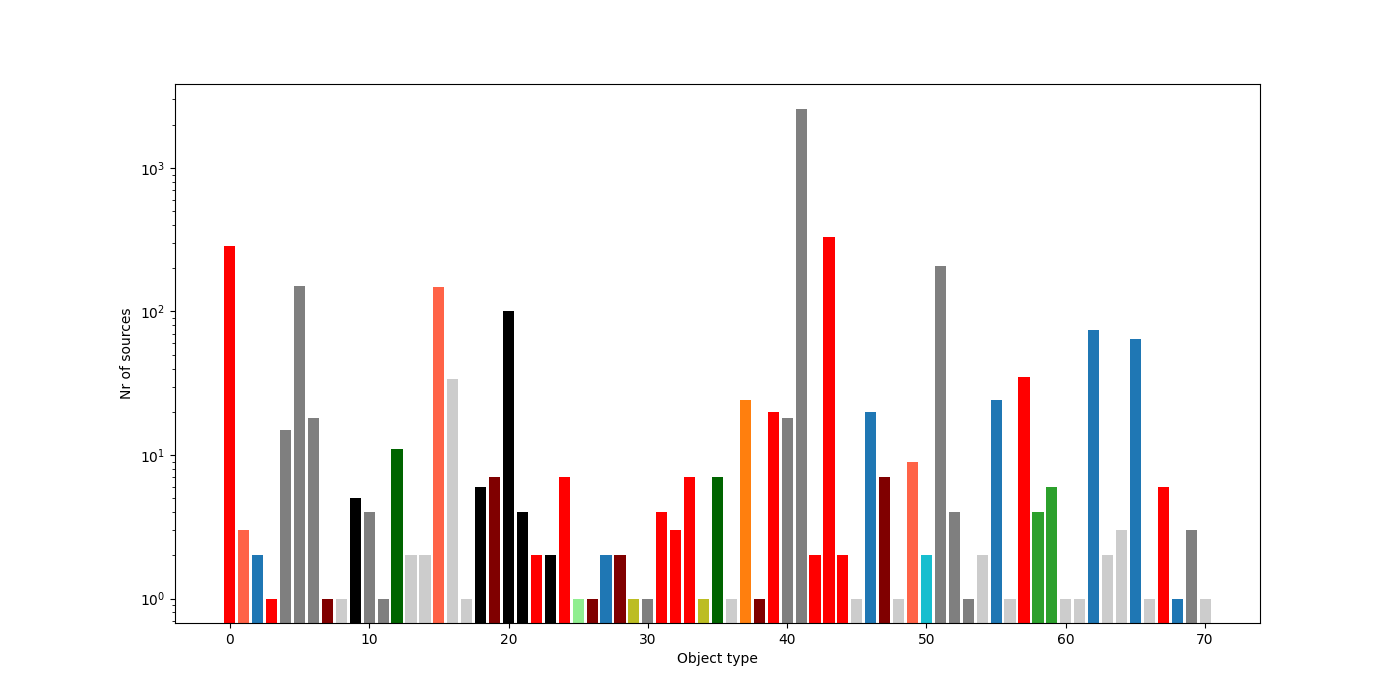

otype Candidate               Description               ogrp     Label                        Category                                          Subcategory                         
                                                                                                                                                                                    
----- --------- --------------------------------------- ---- -------------- ------------------------------------------- ------------------------------------------------------------
    ?        --                Object of Unknown Nature  UNK        Unknown 8. BLENDS, ERRORS, NOT WELL DEFINED OBJECTS                                                           --
    *        --                                    Star Star           Star                        1. TAXONOMY OF STARS                                                           --
   **       **?                 Double or Multiple Star   B*             **                    

In [5]:
sel_mt = rc.tt_sources["sel"]
fig_otypes = plt.figure("Source types",figsize=(14, 7))
fig_otypes.clf()

otypes_all, otype_cts_all= np.unique(rc.tt_sources[sel_mt]["otype"],return_counts=True)
dd_otype2id = dict(zip(list(otypes_all),range(len(otypes_all))))

tt_mt_grp =  rc.tt_sources[sel_mt].group_by("ogrp")
for group, tt_grp in zip(tt_mt_grp.groups.keys, tt_mt_grp.groups):
    otypes, otype_cts= np.unique(tt_grp["otype"],return_counts=True)
    otypes_id = []
    for otype in otypes:
        otypes_id.append(dd_otype2id[otype])
    plt.bar( otypes_id, otype_cts, align='center', label=group[0], color = dd_ogrp2col[group[0]])
plt.yscale('log')
#plt.grid()
plt.xlabel("Object type")
plt.ylabel("Nr of sources")
plt.show()
plt.legend()
plt.xticks(range(len(otypes_all)), otypes_all, size='small')

rc.tt_otypes["otype","Candidate","Description","ogrp","Label","Category","Subcategory"].pprint_all()#show_dtype=True #,"Status","Priority"


### Scatter plots of source variables by group

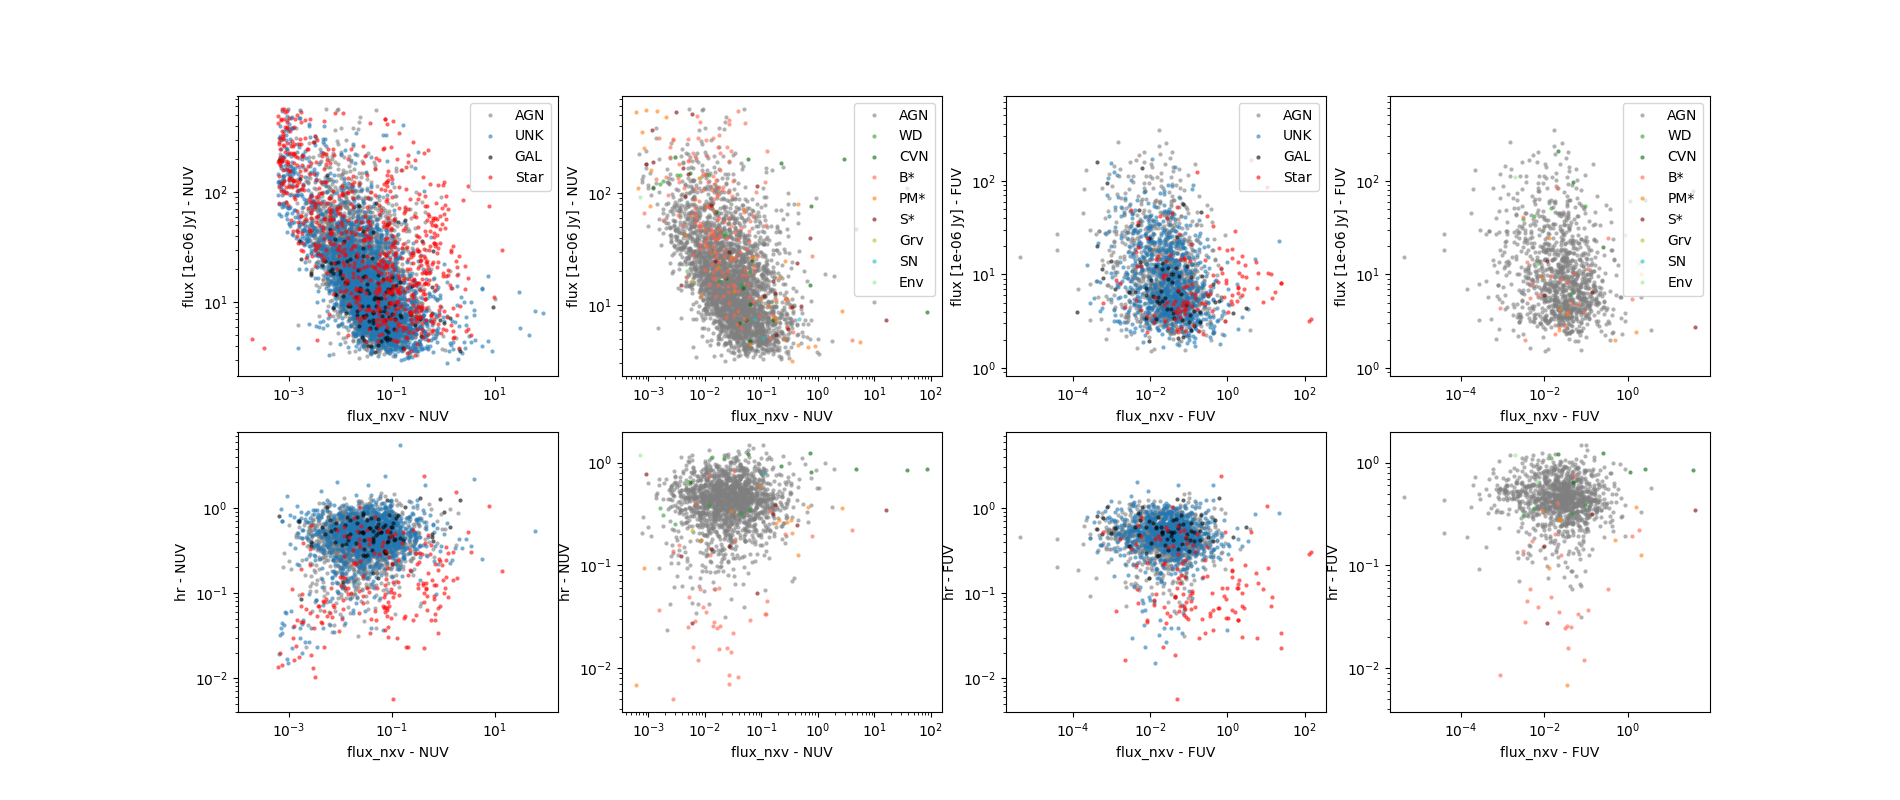

In [6]:
plot_kwargs = {"markersize": 3.0,"alpha":0.6}
fig, axs = plt.subplots(2, 4, figsize=(19, 8))
#fig.clf()
axs = axs.flatten()
plt_ogrops = [["AGN","UNK","GAL",'Star'],["AGN",'WD', 'CVN', 'B*', 'PM*',"S*", 'Grv', 'SN',"Env"]]

plt_flts = [1,2]
ctr = 0
for flt in plt_flts:
    for ogrps in plt_ogrops:
        #axs[ctr].cla()
        axs[ctr].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "flux", ax=axs[ctr], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)

        #axs[ctr+4].cla()
        axs[ctr+4].set_prop_cycle(get_col_cycler(ogrps))
        vvis.plot_table_scatter(rc.tt_sources,"flux_nxv", "hr", ax=axs[ctr+4], xscale="log",yscale="log", obs_filter_id=flt, grp_var="ogrp",grp_vals = ogrps,**plot_kwargs)
        ctr +=1

_ = axs[0].legend()
_ = axs[1].legend()
_ = axs[2].legend()
_ = axs[3].legend()
#print(dd_ogrp2otypes.keys())r

### Print info for selected sources

In [7]:
# Make selection
sel_otype = rc.tt_sources["otype"] ==  "RR*"# "No*"#"HS?" #"BS*" #"PM*" # # "SN*" #"EB*"
sel_otypes = (rc.tt_sources["otype"] ==  "WD?")  + (rc.tt_sources["otype"] =="WD*")
sel_flux_nxv = rc.tt_sources["flux_nxv"][:,0]>2
sel_flux_hr = rc.tt_sources["hr"]>2
sel_src_id = rc.tt_sources["rg_src_id"]==15179
sel_srcs =  sel_otypes  #sel_src_id  #sel_flux_nxv #sel_otype # sel_flux_nxv_fuv # sel_flux_hr#

#Display match and simbad table for selected sources
display(rc.tt_sources[sel_srcs])

#Print oout list of source IDs to be used for further use, e.g. in inspect_sources.ipynb
print("srcs_ids = [", end="")
for src_id in rc.tt_sources[sel_srcs]["rg_src_id"].data:
    print(src_id,",", end="")
print("]")

fd_src_id,nr_det,ra,dec,pos_err,pos_xv,pos_var,pos_cpval,pos_rchiq,coadd_src_id,coadd_dist,obs_filter_id,sel,flux,flux_err,flux_nxv,flux_var,flux_cpval,flux_rchiq,coadd_ffactor,coadd_fdiff_s2n,rg_fd_id,rg_src_id,nr_fd_srcs,hr,hr_err,otype,main_id,otypes,z_value,distance_distance,distance_unit,distance_result,ogrp
,,deg,deg,arcsec,arcsec2,arcsec2,,,,arcsec,,,1e-06 Jy,1e-06 Jy,,1e-12 Jy2,,,,,,,,,,,,,,,,arcsec,
int32,int32[2],float64,float64,float32,float32,float32,float32,float32,int64,float32,int32[2],bool,float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],float32[2],int64,int32,int32,float32,float32,bytes32,bytes32,bytes32,float64,float64,str4,float32,bytes8
-1,14 .. 4,348.90357602965054,19.41375292102418,0.12961677,-0.16667423,0.1757124,0.9601939,0.38698718,178527,0.27343646,1 .. 2,True,127.17284 .. 38.594788,0.6384927 .. 1.9439608,0.0018059316 .. 0.0030419875,36.337494 .. 59.990253,1.3913134e-13 .. 0.45650917,6.9238577 .. 0.86853236,1.002267 .. 1.0705498,0.35846016 .. 1.2124124,-1,55034,2,0.31256443,0.016097367,WD?,SDSS J231536.88+192448.9,blu|Pu*|*|Opt|WD?|WD?,--,168.9270,pc,0.4557,WD
-1,7 .. 2,334.6190008630954,-0.00334150877900888,0.18584667,-0.18340522,0.12893102,0.8110655,0.40349314,198217,0.26084808,1 .. 2,True,121.26046 .. 42.269413,0.7279036 .. 0.8880146,0.0016064999 .. 0.005644754,27.450546 .. 11.66761,2.65163e-07 .. 0.00661471,6.8656754 .. 7.3747196,0.9975268 .. 1.0487088,-0.38367364 .. 1.7196137,-1,61491,2,0.35823846,0.011588516,WD*,PB 5130,WD*|WD*|WD*|WD*|*|Opt|UV|WD?|WD?,1.3299500,121.7450,pc,0.3802,WD
-1,32 .. 4,333.54135905569626,0.8794295342456827,0.106176615,-0.26969245,0.14336883,0.9997828,0.34498087,208406,0.11125645,1 .. 2,True,19.849901 .. 5.189896,0.17154492 .. 0.40037686,0.06351051 .. -0.020882767,26.03123 .. 0.08260181,0.0 .. 0.9400651,26.48837 .. 0.13361953,0.94128394 .. 1.0394988,-5.53346 .. 0.3762283,-1,64360,2,0.34424755,0.02826839,WD*,GALEX J221409.8+005245,WD*|WD*|WD*|*|Opt|UV,--,439.0000,pc,0.2767,WD
-1,18 .. 6,303.01100514369136,-48.394108786088324,0.11078485,-0.1118269,0.21495172,0.59480566,0.64826185,236659,0.16462971,1 .. 2,True,145.71655 .. 53.254395,0.65051293 .. 1.6317714,0.011681384 .. 0.09355949,262.29507 .. 336.1793,0.0 .. 4.538933e-19,41.07661 .. 19.113188,0.9875043 .. 0.92640793,-2.2628753 .. -1.732858,-1,73354,2,0.38933843,0.012308751,WD?,Gaia DR3 6669015352243852800,*|WD?,--,--,,0.3998,WD
-1,25 .. 12,261.0003596219375,60.74772407491583,0.09249079,-0.12485813,0.21191294,0.78836334,0.5457976,245032,0.072778955,1 .. 2,True,43.02675 .. 51.450314,0.27040577 .. 0.68775964,0.021784516 .. 0.014586984,42.229954 .. 74.628174,0.0 .. 9.499622e-33,27.235014 .. 16.378187,0.9762591 .. 0.9339476,-2.9283037 .. -4.3375144,-1,76243,2,1.0981839,0.017458435,WD?,ZTF J172400.04+604451.8,EB*|*|WD?|WD?,--,--,,0.2700,WD
-1,15 .. -1,244.14364475974057,54.16992508668509,0.14302015,-0.149046,0.15964259,0.6340721,0.52604604,71751,0.20260328,1 .. 0,False,43.955715 .. -1.0,0.373552 .. -1.0,0.023890479 .. -100.0,48.38352 .. -1.0,0.0 .. -1.0,23.603268 .. -1.0,0.990053 .. -100.0,-1.0570939 .. -10000.0,-1,92867,2,-1.0,-1.0,WD?,GALEX J161634.4+541011,*|*|Opt|UV|WD?|WD?,--,93.6920,pc,1.0158,WD
-1,21 .. 1,219.22854193199083,34.06670048559544,0.11800814,-0.10925614,0.2025599,0.68355554,0.61700284,351692,0.035019293,1 .. 2,True,30.282242 .. 37.433167,0.3364404 .. 3.059399,0.013331741 .. -100.0,19.445185 .. -100.0,4.734923e-28 .. -1.0,9.079622 .. -1.0,1.0011699 .. 0.9832684,0.090507984 .. -0.18113555,-1,104078,2,1.1301088,0.1134821,WD?,GALEX J143654.8+340400,*|UV|WD?|WD?,--,--,,0.2658,WD
-1,18 .. 8,218.05243811169709,35.840903328171464,0.12735511,-0.29414088,0.17379755,0.96632844,0.39901668,361741,0.07959464,1 .. 2,True,14.915235 .. 6.4086227,0.24988876 .. 0.38860035,0.04386847 .. 0.04654254,12.461055 .. 3.405273,3.1348733e-25 .. 0.030883376,9.390375 .. 2.204061,0.95756274 .. 0.97631735,-2.0785728 .. -0.309062,-1,106745,2,0.32614058,0.026615512,WD?,Gaia DR2 1480420251349953920,*|WD?,--,--,,0.2143

srcs_ids = [55034 ,61491 ,64360 ,73354 ,76243 ,92867 ,104078 ,106745 ,226975 ,267514 ,588567 ,599887 ,]


Identified sources:
1) 150.38873296492392	1.7245661255048343; GNU2605264352416104448 PS_COSMOS_MOS26; LINEAR 21145823;RR*;Very large flux_nxv_fuv=47 and very low hr 0.026; 

In [8]:
from astroquery.simbad import Simbad

testSimbad = Simbad()

#testSimbad.list_votable_fields()
all_vo_fields = ["biblio","cel","cl.g","coo(opt)","coo_bibcode","coo_err_angle","coo_err_maja","coo_err_mina","coo_qual","coo_wavelength","coordinates","dec(opt)","dec_prec","diameter","dim","dim_angle","dim_bibcode","dim_incl","dim_majaxis","dim_minaxis","dim_qual","dim_wavelength","dimensions","distance","distance_result","einstein","fe_h","flux(filtername)","flux_bibcode(filtername)","flux_error(filtername)","flux_name(filtername)","flux_qual(filtername)","flux_system(filtername)","flux_unit(filtername)","fluxdata(filtername)","gcrv","gen","gj","hbet","hbet1","hgam","id(opt)","ids","iras","irc","iso","iue","jp11","link_bibcode","main_id","measurements","membership","mesplx","mespm","mk","morphtype","mt","mt_bibcode","mt_qual","otype","otype(opt)","otypes","parallax","plx","plx_bibcode","plx_error","plx_prec","plx_qual","pm","pm_bibcode","pm_err_angle","pm_err_maja","pm_err_mina","pm_qual","pmdec","pmdec_prec","pmra","pmra_prec","pos","posa","propermotions","ra(opt)","ra_prec","rot","rv_value","rvz_bibcode","rvz_error","rvz_qual","rvz_radvel","rvz_type","rvz_wavelength","sao","sp","sp_bibcode","sp_nature","sp_qual","sptype","td1","typed_id","ubv","uvby","uvby1","v*","velocity","xmm","z_value"]

#for vo_field in all_vo_fields:
#    print("*",vo_field)
#    testSimbad.get_field_description(vo_field)